# Projet de Deep Learning :


=========== projet 6: prediction série temporelle =========

Nous considérons une série temporelle financière donnée de longueur totale N, S_t, t=0,1,...,N.
Nt=0.8*N (entrainement), Nv=0.2*N (validation) à télécharger sur internet ou à prendre une colonne dans 
https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv

Exemple N=255*10 (10 années de données journalières)

On calcule pour chaque point de la série initiale 
- les rendements R_t = np.log(X_t/X_{t-1})
- la moyenne des K derniers rendements, K=5 (=1 semaine: 1W), K=25 (1 mois: 1M), K=3*25 (3M); K=6*25 (6M), K=255 (1Y), K=3Y
- la volatilité (annualisée) des K derniers rendements sur la même période

On ajoute pour chaque point : 
- les calculs précédents (1+7*2 = 15 données)
- le prix en 't', (1 donnée)
- la moyenne exponentielle (EMA) des derniers K prix divisé par le prix en t (7 données)
- une fenetre de longueur "n" des prix S_{t-n} ... S_t,  par exemple n=3*25 (3 mois) : n données .

Attention: parfois il n'est pas possible de calculer par exemple la moyenne sur les 3 dernières année car pas assez de données. Alors la prendre égale à la plus longue qu'il est possible de calculer (ne pas mettre "nan").

Donc la base de données contient N-1 points.
A prevoir: le rendement suivant en R_{t+1}


In [57]:
# 0) Chargement des bibliothèques + seed
# --------------------------------------

import numpy as np
import pandas as pd
import pandas_ta as ta

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os

# Pour la régression linéaire
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Pour le réseau de neurones (Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


# Fixation du seed pour la reproductibilité
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Libraries loaded and random seed fixed.")


Libraries loaded and random seed fixed.


# 1) Lecture des données (depuis l'URL) et prétraitement

In [58]:
# ------------------------------------------------------

# URL des données
url = "https://turinici.com/wp-content/uploads/cours/common/close_cac40_historical.csv"

# Lecture du fichier CSV en ne chargeant que la colonne 'BNP.PA'
df_raw = pd.read_csv(url, sep=";", usecols=["Date", "BNP.PA"])

# Renommage des colonnes 
df_raw.rename(columns={"BNP.PA": "Price"}, inplace=True)

# Conversion de la colonne 'Date' en format datetime (si ce n'est pas déjà le cas)
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Définir la colonne 'Date' comme index
df_raw.set_index("Date", inplace=True)

# Affichage des premières lignes et dimensions
print("\nAperçu des premières lignes :")
display(df_raw.head())
print("\nDimensions initiales :", df_raw.shape)

# Retirer les lignes contenant des NaN dans la colonne 'Price'
df_raw.dropna(subset=["Price"], inplace=True)

# Tri par index (date) pour s'assurer de l'ordre chronologique
df_raw.sort_index(inplace=True)

# Vérification après nettoyage
print("\nAperçu après nettoyage :")
display(df_raw.head())
print("\nDimensions après nettoyage :", df_raw.shape)




Aperçu des premières lignes :


,Price
Date,
2000-01-03,16.165972
2000-01-04,15.711578
2000-01-05,15.379528
2000-01-06,14.855226
2000-01-07,15.047465



Dimensions initiales : (8605, 1)

Aperçu après nettoyage :


,Price
Date,
1993-10-18,4.227787
1993-10-19,4.120383
1993-10-20,4.149676
1993-10-21,4.218023
1993-10-22,4.315662



Dimensions après nettoyage : (7339, 1)


# 2) Feature Engineering

In [59]:
# ----------------------
# - Calcul des rendements log (R_t = log(X_t / X_{t-1}))
# - Moyennes mobiles sur K jours, volatilités annualisées
# - EMA (Exponentially Moving Average) / Price
# - Fenêtre glissante n = 3 * 25

df = df_raw.copy()

# 2.1 Rendement log
df["Return"] = np.log(df["Price"] / df["Price"].shift(1))
df.dropna(inplace=True)  # retire la première ligne NaN

# 2.2 Définition des horizons K
K_list = [5, 25, 75, 150, 252, 3*252]  # 1W, 1M, 3M, 6M, 1Y, 3Y
# Filtrons si la base est trop courte pour calculer 3 ans
K_list = [K for K in K_list if K < len(df)]

# Calculs (moyenne mobile des rendements + volatilité annualisée)
for K in K_list:
    # Moyenne des K derniers rendements
    df[f"meanRet_{K}"] = df["Return"].rolling(K).mean()
    df[f"meanRet_{K}"].fillna(method="bfill", inplace=True)

    # Volatilité annualisée sur K derniers rendements
    df[f"vol_{K}"] = df["Return"].rolling(K).std() * np.sqrt(252)
    df[f"vol_{K}"].fillna(method="bfill", inplace=True)


# 2.4 EMA(K) / Price
for K in K_list:
    ema_series = df["Price"].ewm(span=K, adjust=False).mean()
    df[f"emaRatio_{K}"] = ema_series / df["Price"]
    df[f"emaRatio_{K}"].fillna(method="bfill", inplace=True)

# 2.5 Fenêtre glissante
n = 25 * 3
for i in range(n):
    df[f"Price_lag_{i+1}"] = df["Price"].shift(i+1)

df.dropna(inplace=True)

# 2.6 Cible = Rendement futur R_{t+1}

df["FutureReturn"] = df["Return"].shift(-1)
df.dropna(inplace=True)

print(f"\nDimensions après feature engineering : {df.shape}")

# 2.7 Sélection des features (X) et de la cible (y)
exclude_cols = ["Price", "Return", "FutureReturn"]
feature_cols = [c for c in df.columns if c not in exclude_cols]
X = df[feature_cols].values
y = df["FutureReturn"].values

# 2.8 Normalisation (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Feature scaling terminé.")





Dimensions après feature engineering : (7262, 96)
Feature scaling terminé.


C:\Users\ugo11\AppData\Local\Temp\ipykernel_3936\933299551.py:22: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



C:\Users\ugo11\AppData\Local\Temp\ipykernel_3936\933299551.py:22: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\ugo11\AppData\Local\Temp\ipykernel_3936\933299551.py:26: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will chan

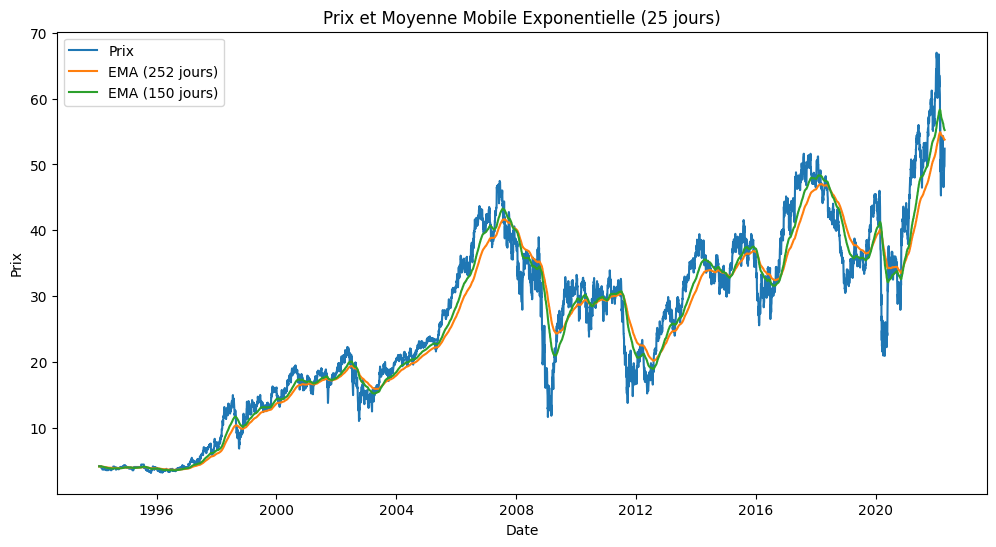

In [60]:
# Exemple de visualisation : prix et EMA

plt.figure(figsize=(12, 6))
plt.plot(df.index, df["Price"], label="Prix")
plt.plot(df.index, df["Price"] * df["emaRatio_252"], label="EMA (252 jours)")
plt.plot(df.index, df["Price"] * df["emaRatio_150"], label="EMA (150 jours)")
plt.title("Prix et Moyenne Mobile Exponentielle (25 jours)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.show()


# 3) Séparation temporelle (Train=80%, Test=20%)


In [61]:
# ----------------------------------------------
N = len(df)
Nt = int(0.8 * N)   # Nt := N_Train
Nv = N - Nt # Nv := N_Test

X_train, X_test = X_scaled[:Nt], X_scaled[Nt:]
y_train, y_test = y[:Nt], y[Nt:]

print("\nTaille dataset complet :", N)
print("Taille train :", Nt)
print("Taille test :", Nv)


Taille dataset complet : 7262
Taille train : 5809
Taille test : 1453


# 4) Modèle de Regression Linéaire

In [62]:
# Régression linéaire
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

# Évaluation des performances
mse_lin = mean_squared_error(y_test, y_pred_lin)
print(f"\nRégression Linéaire - MSE test : {mse_lin:.6f}")



Régression Linéaire - MSE test : 0.000473


In [63]:
# Calcul de l'erreur
errors = np.array(y_test) - np.array(y_pred_lin)

# Création de la figure interactive
fig = go.Figure()

# Ajout des vrais rendements
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred_lin))),
    y=y_pred_lin,
    mode='lines+markers',
    name='Prédictions (Régression Linéaire)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs
fig.add_trace(go.Scatter(
    x=list(range(len(errors))),
    y=errors,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

# Mise en forme de la figure
fig.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (Régression Linéaire)",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    grid=dict(rows=1, columns=1),
    template="plotly_white"
)

# Affichage de la figure
fig.show()


# 5) Modèle de Réseaux de Neuronnes simple

In [64]:

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),  
    Dropout(0.3),  
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='linear')  
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entraînement
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,  
    batch_size=32,  
    verbose=1
)

# Évaluation sur le jeu de test
mse_nn = model.evaluate(X_test, y_test, verbose=0)
print(f"\nRéseau de Neurones - MSE test : {mse_nn:.6f}")


c:\Users\ugo11\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9966 - val_loss: 0.0174
Epoch 2/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1311 - val_loss: 0.0241
Epoch 3/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0652 - val_loss: 0.0297
Epoch 4/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0390 - val_loss: 0.0039
Epoch 5/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0243 - val_loss: 0.0093
Epoch 6/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0176 - val_loss: 0.0058
Epoch 7/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0012
Epoch 8/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - val_loss: 9.2456e-04
Epoch 9/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - val_loss: 0.0023
Epoch 10/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0055 - val_loss: 7.8095e-04
Epoch 11/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 12/50
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 

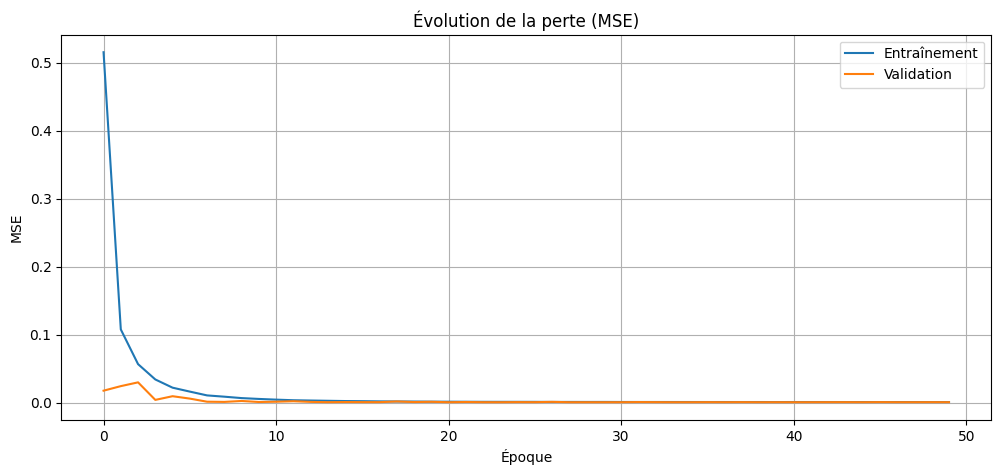

In [65]:
# Courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Évolution de la perte (MSE)')
plt.xlabel('Époque')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()


In [66]:
# Prédictions sur le jeu de test
y_pred = model.predict(X_test).flatten()

# Calcul de l'erreur
errors = np.array(y_test) - np.array(y_pred)

# Création de la figure interactive avec Plotly
fig = go.Figure()

# Ajout des vrais rendements
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred))),
    y=y_pred,
    mode='lines+markers',
    name='Prédictions (Réseau de Neurones)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs
fig.add_trace(go.Scatter(
    x=list(range(len(errors))),
    y=errors,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

# Mise en forme de la figure interactive
fig.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (Réseau de Neurones)",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    template="plotly_white"
)

# Affichage de la figure interactive
fig.show()



46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


# 6) Modèle LSTM

In [ ]:
'''for i in range(1, 76):
    df_lstm = df.drop(columns=[f'Price_lag_{i}'], inplace=False)'''
    
exclude_cols = ["Price", "Return", "FutureReturn"]
feature_cols = [c for c in df_lstm.columns if c not in exclude_cols]
X = df_lstm[feature_cols].values
y = df_lstm["FutureReturn"].values

# 2.8 Normalisation (StandardScaler)
scaler = StandardScaler()
X_scaled_lstm = scaler.fit_transform(X)

# ----------------------------------------------
N = len(df_lstm)
Nt = int(0.8 * N)   # Nt := N_Train
Nv = N - Nt # Nv := N_Test

X_train, X_test = X_scaled_lstm[:Nt], X_scaled_lstm[Nt:]
y_train, y_test = y[:Nt], y[Nt:]

print("\nTaille dataset complet :", N)
print("Taille train :", Nt)
print("Taille test :", Nv)

In [ ]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)


seq_length = 75  # Longueur des séquences temporelles 3 mois 
X_train_seq, y_train_seq = create_sequences(X_train, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, seq_length)

print(f"Forme X_train_seq : {X_train_seq.shape}")
print(f"Forme y_train_seq : {y_train_seq.shape}")

# Modèle LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(seq_length, X_train_seq.shape[2])),
    tf.keras.layers.LSTM(64, return_sequences=True, activation='relu'),  # Première couche LSTM
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.LSTM(64, return_sequences=False, activation='relu'),  # Deuxième couche LSTM
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])



model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Entraînement
history_lstm = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Évaluation
mse_lstm = model_lstm.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f"\nLSTM - MSE test : {mse_lstm:.6f}")
#0.004


In [ ]:
# Courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))
plt.plot(history_lstm.history['loss'], label='Entraînement')
plt.plot(history_lstm.history['val_loss'], label='Validation')
plt.title('Évolution de la perte (MSE)')
plt.xlabel('Époque')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Prédictions sur le jeu de test
y_pred = model_lstm.predict(X_test_seq).flatten()

# Calcul de l'erreur
errors = np.array(y_test_seq) - np.array(y_pred)

# Création de la figure interactive avec Plotly
fig = go.Figure()

# Ajout des vrais rendements
fig.add_trace(go.Scatter(
    x=list(range(len(y_test_seq))),
    y=y_test_seq,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred))),
    y=y_pred,
    mode='lines+markers',
    name='Prédictions (Réseau de Neurones)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs
fig.add_trace(go.Scatter(
    x=list(range(len(errors))),
    y=errors,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

# Mise en forme de la figure interactive
fig.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (LSTM)",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    template="plotly_white"
)

# Affichage de la figure interactive
fig.show()



# 7) TFT Modèle

Features engineering pour le modèle TFT on va ajouter des features :

-RSI
-MACD
-Bande de Bollinger
-Momentum et Rate Of Change (ROC)

In [86]:
# Copie du DataFrame original
df_TFT = df.copy()

# Ajout des indicateurs techniques
df_TFT["RSI_14"] = ta.rsi(df_TFT["Price"], length=14)

# Ajout du MACD
macd = ta.macd(df_TFT["Price"])
df_TFT["MACD"] = macd["MACD_12_26_9"]
df_TFT["MACD_Signal"] = macd["MACDs_12_26_9"]
df_TFT["MACD_Hist"] = macd["MACDh_12_26_9"]

# Ajout des Bandes de Bollinger
bbands = ta.bbands(df_TFT["Price"], length=20, std=2)
df_TFT["BB_Lower"] = bbands["BBL_20_2.0"]
df_TFT["BB_Mid"] = bbands["BBM_20_2.0"]
df_TFT["BB_Upper"] = bbands["BBU_20_2.0"]

# Ajout du Momentum et du ROC (Rate of Change)
df_TFT["Momentum_5"] = ta.mom(df_TFT["Price"], length=5) 
df_TFT["ROC_5"] = ta.roc(df_TFT["Price"], length=5)     


# Suppression des lignes NaN
df_TFT.dropna(inplace=True)

# Vérification et correction des types des colonnes (si nécessaire)
for col in ["RSI_14", "MACD", "MACD_Signal", "MACD_Hist", "BB_Lower", "BB_Mid", "BB_Upper", "Momentum_5", "ROC_5"]:
    df_TFT[col] = pd.to_numeric(df_TFT[col], errors='coerce')

# Suppression des lignes NaN après correction
df_TFT.dropna(inplace=True)

# Sélection des features et cible
exclude_cols = ["Price", "Return", "FutureReturn"]
feature_cols = [c for c in df_TFT.columns if c not in exclude_cols]

X_TFT = df_TFT[feature_cols].values
y_TFT = df_TFT["FutureReturn"].values

# Normalisation des features
scaler = StandardScaler()
X_scaled_TFT = scaler.fit_transform(X_TFT)

display(df_TFT)




,Price,Return,meanRet_5,vol_5,meanRet_25,vol_25,meanRet_75,vol_75,meanRet_150,vol_150,...,FutureReturn,RSI_14,MACD,MACD_Signal,MACD_Hist,BB_Lower,BB_Mid,BB_Upper,Momentum_5,ROC_5
Date,,,,,,,,,,,,,,,,,,,,,
1994-03-18,3.720063,0.000000,0.000000,0.000000,-0.005118,0.281329,-0.001426,0.243634,-0.001048,0.217251,...,0.000000,0.000000,-0.145683,-0.128378,-0.017304,3.593132,3.948539,4.303945,0.000000,0.000000
1994-03-21,3.720063,0.000000,0.000000,0.000000,-0.005118,0.281329,-0.001426,0.243634,-0.001048,0.217251,...,0.000000,0.000000,-0.143736,-0.131450,-0.012286,3.578798,3.923153,4.267508,0.000000,0.000000
1994-03-22,3.720063,0.000000,0.000000,0.000000,-0.005118,0.281329,-0.001426,0.243634,-0.001048,0.217251,...,0.000000,0.000000,-0.140572,-0.133274,-0.007298,3.572665,3.897766,4.222868,0.000000,0.000000
1994-03-23,3.720063,0.000000,0.000000,0.000000,-0.005118,0.281329,-0.001426,0.243634,-0.001048,0.217251,...,0.000000,0.000000,-0.136492,-0.133918,-0.002574,3.576329,3.872380,4.168432,0.000000,0.000000
1994-03-24,3.720063,0.000000,0.000000,0.000000,-0.005118,0.281329,-0.001426,0.243634,-0.001048,0.217251,...,-0.005263,0.000000,-0.131739,-0.133482,0.001743,3.593132,3.846994,4.100856,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-13,48.924999,0.004404,0.006777,0.266117,-0.001990,0.451826,-0.002878,0.482373,-0.000427,0.390201,...,0.011785,42.837154,-1.556187,-1.529198,-0.026989,46.349289,50.828500,55.307710,1.630001,3.446456
2022-04-14,49.505001,0.011785,0.012266,0.176588,0.000129,0.434540,-0.002712,0.483107,-0.000414,0.390296,...,0.004836,44.926997,-1.436115,-1.510581,0.074466,46.257962,50.651250,55.044537,2.945000,6.325171
2022-04-19,49.744999,0.004836,0.007789,0.119369,0.000579,0.434230,-0.002669,0.483240,-0.000305,0.390085,...,0.029415,45.809838,-1.306530,-1.469771,0.163241,46.242687,50.471000,54.699312,1.899998,3.971152


In [88]:
# ----------------------------------------------
N_TFT = len(df_TFT)
Nt_TFT = int(0.8 * N_TFT)   # Nt := N_Train
Nv_TFT = N_TFT - Nt_TFT # Nv := N_Test

X_train_TFT, X_test_TFT = X_scaled_TFT[:Nt_TFT], X_scaled_TFT[Nt_TFT:]
y_train_TFT, y_test_TFT = y_TFT[:Nt_TFT], y_TFT[Nt_TFT:]

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)


seq_length = 75  
X_train_seq_TFT, y_train_seq_TFT = create_sequences(X_train_TFT, y_train_TFT, seq_length)
X_test_seq_TFT, y_test_seq_TFT = create_sequences(X_test_TFT, y_test_TFT, seq_length)

In [ ]:

# Positional Encoding Class
class PositionalEncoding(layers.Layer):
    def __init__(self, max_position, d_model):
        super().__init__()
        self.d_model = d_model
        # Create the positional encoding matrix
        pe = np.zeros((max_position, d_model))
        position = np.arange(0, max_position)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        # Apply sine to even indices, cosine to odd indices
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        self.pe = tf.constant(pe, dtype=tf.float32)

    def call(self, x):
        # Add positional encoding to input
        seq_length = tf.shape(x)[1]
        x = x + self.pe[:seq_length, :]
        return x

# GatedLinearUnit Class
class GatedLinearUnit(layers.Layer):
    def __init__(self, units):
        super(GatedLinearUnit, self).__init__()
        self.dense = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation='sigmoid')

    def call(self, inputs):
        return self.dense(inputs) * self.sigmoid(inputs)

# Temporal Fusion Transformer
class TemporalFusionTransformer:
    def __init__(self, seq_length, num_features, d_model=64, num_heads=4, dff=128, num_layers=2, dropout_rate=0.1):
        self.seq_length = seq_length
        self.num_features = num_features
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.num_layers = num_layers
        self.dropout_rate = dropout_rate

    def build_model(self):
        inputs = layers.Input(shape=(self.seq_length, self.num_features))

        # Embedding features
        x = layers.Dense(self.d_model)(inputs)

        # Add positional encoding
        x = PositionalEncoding(self.seq_length, self.d_model)(x)

        # Transformer Encoder Layers
        for _ in range(self.num_layers):
            x = TransformerEncoderLayer(self.d_model, self.num_heads, self.dff, self.dropout_rate)(x)

        # Pooling
        x = layers.GlobalAveragePooling1D()(x)

        # Gating mechanism
        x = GatedLinearUnit(self.d_model)(x)

        # Dense for regression
        x = layers.Dense(32, activation='relu')(x)
        outputs = layers.Dense(1)(x)

        model = models.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
        return model

num_features = X_train_seq_TFT.shape[2]

# Instanciation du modèle TFT
tft = TemporalFusionTransformer(seq_length=seq_length, num_features=num_features)
model_TFT = tft.build_model()

# Résumé du modèle
model_TFT.summary()

# Entraînement du modèle
history_TFT = model_TFT.fit(
    X_train_seq_TFT, y_train_seq_TFT,
    validation_data=(X_test_seq_TFT, y_test_seq_TFT),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Évaluation du modèle
mse_TFT = model_TFT.evaluate(X_test_seq_TFT, y_test_seq_TFT, verbose=0)
print(f"TFT - MSE Test : {mse_TFT:.6f}")


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 75, 102)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 75, 64)         │         6,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding_2           │ (None, 75, 64)         │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_layer_6     │ (None, 75, 64)         │        83,200 │
│ (TransformerEncoderLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_layer_7     │ (None, 75, 64)         │        83,200 │
│ (TransformerEncoderLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gated_linear_unit_2             │ (None, 64)             │         8,320 │
│ (GatedLinearUnit)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,425 (716.50 KB)

 Trainable params: 183,425 (716.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 100ms/step - loss: 0.0189 - val_loss: 0.0039
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 146ms/step - loss: 0.0011 - val_loss: 0.0074
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - loss: 0.0010 - val_loss: 0.0022
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 146ms/step - loss: 8.6960e-04 - val_loss: 0.0024
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 26s 142ms/step - loss: 8.1676e-04 - val_loss: 0.0019
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 25s 137ms/step - loss: 8.0673e-04 - val_loss: 0.0020
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - loss: 7.7952e-04 - val_loss: 0.0015
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 23s 128ms/step - loss: 7.6894e-04 - val_loss: 0.0015

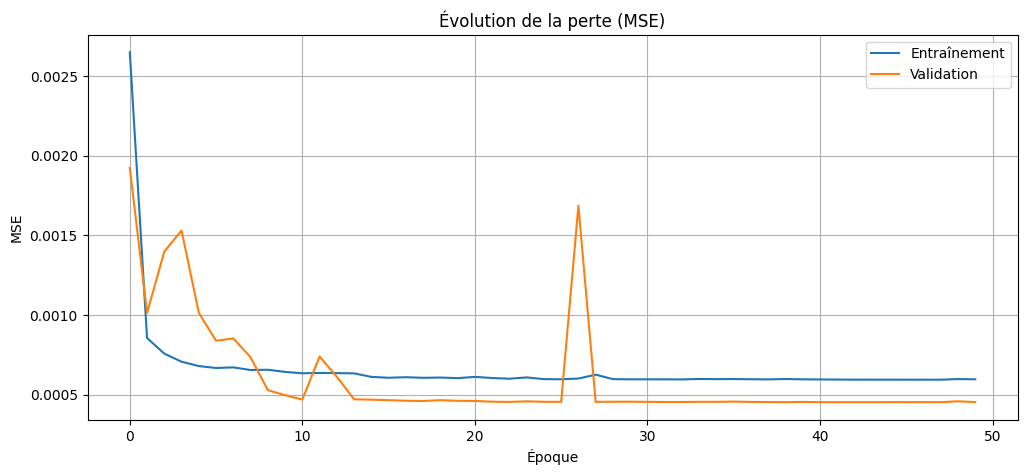

In [ ]:
# Courbes d'entraînement et de validation
plt.figure(figsize=(12, 5))
plt.plot(history_TFT.history['loss'], label='Entraînement')
plt.plot(history_TFT.history['val_loss'], label='Validation')
plt.title('Évolution de la perte (MSE)')
plt.xlabel('Époque')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Prédictions sur le jeu de test
y_pred = model_TFT.predict(X_test_seq_TFT).flatten()

# Calcul de l'erreur
errors = np.array(y_test_seq_TFT) - np.array(y_pred)

# Création de la figure interactive avec Plotly
fig = go.Figure()

# Ajout des vrais rendements
fig.add_trace(go.Scatter(
    x=list(range(len(y_test_seq_TFT))),
    y=y_test_seq_TFT,
    mode='lines+markers',
    name='Vrais rendements (Réels)',
    line=dict(color='blue', dash='solid'),
    marker=dict(symbol='circle'),
    opacity=0.7
))

# Ajout des prédictions
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred))),
    y=y_pred,
    mode='lines+markers',
    name='Prédictions (Modèle TFT)',
    line=dict(color='red', dash='dash'),
    marker=dict(symbol='x'),
    opacity=0.7
))

# Ajout des erreurs
fig.add_trace(go.Scatter(
    x=list(range(len(errors))),
    y=errors,
    mode='lines+markers',
    name='Erreur (Vrais - Prédictions)',
    line=dict(color='green', dash='dot'),
    marker=dict(symbol='triangle-up'),
    opacity=0.7
))

# Mise en forme de la figure interactive
fig.update_layout(
    title="Vrais rendements VS Prédictions et Erreur (TFT))",
    xaxis_title="Index Chronologique",
    yaxis_title="Rendement",
    legend=dict(font=dict(size=12)),
    template="plotly_white"
)

# Affichage de la figure interactive
fig.show()
